# GC-bias analysis on Mycoplasma genitalium G37
Using genome NC_000908.2 and reads SRR28800590 to evaluate CoverM's GC-bias correction.


In [1]:

import os, subprocess, random, pandas as pd
from pathlib import Path


In [2]:
# Download genome if not present
if not Path('NC_000908.2.fna').exists():
    subprocess.run(['curl','-L','-o','NC_000908.2.fna','https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nuccore&id=NC_000908.2&rettype=fasta&retmode=text'], check=True)
# Download reads if not present
if not Path('SRR28800590_1.fastq.gz').exists():
    subprocess.run(['curl','-L','-o','SRR28800590_1.fastq.gz','https://ftp.sra.ebi.ac.uk/vol1/fastq/SRR288/090/SRR28800590/SRR28800590_1.fastq.gz'], check=True)
    subprocess.run(['curl','-L','-o','SRR28800590_2.fastq.gz','https://ftp.sra.ebi.ac.uk/vol1/fastq/SRR288/090/SRR28800590/SRR28800590_2.fastq.gz'], check=True)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 48.3M    0  7748    0     0  11064      0  1:16:24 --:--:--  1:16:24 11068

  0 48.3M    0  273k    0     0   218k      0  0:03:46  0:00:01  0:03:45  218k

 37 48.3M   37 18.1M    0     0  8304k      0  0:00:05  0:00:02  0:00:03 8303k

 70 48.3M   70 34.1M    0     0  10.5M      0  0:00:04  0:00:03  0:00:01 10.5M

100 48.3M  100 48.3M    0     0  11.1M      0  0:00:04  0:00:04 --:--:-- 13.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 50.1M    0 23748    0     0  28622      0  0:30:36 --:--:--  0:30:36 28612

 16 50.1M   16 8710k    0     0  4765k      0  0:00:10  0:00:01  0:00:09 4765k

 67 50.1M   67 34.0M    0     0  12.0M      0  0:00:04  0:00:02  0:00:02 12.0M

100 50.1M  100 50.1M    0     0  14.7M      0  0:00:03  0:00:03 --:--:-- 14.8M


In [3]:

# Generate random contigs with ~10kb average length
seq=''.join(open('NC_000908.2.fna').read().splitlines()[1:])
L=len(seq)
mean=10000
contigs=[]
starts=[]
pos=0
idx=1
while pos < L:
    length=int(random.expovariate(1/mean))
    if length<1000:
        length=1000
    end=min(pos+length,L)
    contigs.append((f'contig_{idx}', seq[pos:end]))
    starts.append(pos)
    pos=end
    idx+=1
with open('g37_contigs.fna','w') as out:
    for name,seqc in contigs:
        out.write('>'+name+'\n')
        out.write('\n'.join(seqc[i:i+60] for i in range(0,len(seqc),60)))
        out.write('\n')
with open('contig_positions.tsv','w') as f:
    f.write('contig\tstart\n')
    for name,start in zip([c[0] for c in contigs], starts):
        f.write(f'{name}\t{start}\n')
print('Generated', len(contigs), 'contigs')


Generated 46 contigs


In [4]:

# Map reads to contigs using CoverM
bam_path=Path('g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam')
if not bam_path.exists():
    subprocess.run(['./target/debug/coverm','make','-r','g37_contigs.fna','-1','SRR28800590_1.fastq.gz','-2','SRR28800590_2.fastq.gz','-o','g37_mapping'], check=True)
else:
    print('BAM already exists')


[2025-08-23T12:53:09Z INFO  bird_tool_utils::clap_utils] CoverM version 0.7.0
[2025-08-23T12:53:09Z INFO  bird_tool_utils::external_command_checker] Found strobealign version 0.14.0 
[2025-08-23T12:53:09Z INFO  bird_tool_utils::external_command_checker] Found samtools version 1.21 
[2025-08-23T12:53:09Z INFO  coverm] Writing BAM files to already existing directory g37_mapping
[2025-08-23T12:53:09Z INFO  coverm] Not pre-generating strobealign index
[2025-08-23T12:53:09Z INFO  coverm] Running mapping number 1 ..


In [5]:

# Run GC-bias correction
subprocess.run(['./target/debug/coverm','gc-bias','-b','g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam','-r','g37_contigs.fna','--plot','gc_bias.png'], check=True, stdout=open('gc_bias.tsv','w'))


[2025-08-23T12:53:50Z INFO  bird_tool_utils::clap_utils] CoverM version 0.7.0


CompletedProcess(args=['./target/debug/coverm', 'gc-bias', '-b', 'g37_mapping/g37_contigs.fna.SRR28800590_1.fastq.gz.bam', '-r', 'g37_contigs.fna', '--plot', 'gc_bias.png'], returncode=0)

In [6]:
# Analyze results for first vs second half
pos = pd.read_csv('contig_positions.tsv', sep='	')
res = pd.read_csv('gc_bias.tsv', sep='	', header=None,
                 names=['contig','adjusted_coverage','coverage','gc_percent'])
print(res.head())
midpoint = len(seq)//2
pos['region'] = pos['start'].apply(lambda s: 'first_half' if s < midpoint else 'second_half')
merged = pos.merge(res, on='contig')
first_adj = merged[merged['region']=='first_half']['adjusted_coverage'].mean()
second_adj = merged[merged['region']=='second_half']['adjusted_coverage'].mean()
first_orig = merged[merged['region']=='first_half']['coverage'].mean()
second_orig = merged[merged['region']=='second_half']['coverage'].mean()
print('Mean original coverage first half:', first_orig)
print('Mean original coverage second half:', second_orig)
print('Mean adjusted coverage first half:', first_adj)
print('Mean adjusted coverage second half:', second_adj)
merged.head()


     contig  adjusted_coverage    coverage  gc_percent
0  contig_1         447.546562  444.151052   29.041539
1  contig_2         453.642068  446.863689   28.586941
2  contig_3         448.070466  443.056960   29.532473
3  contig_4         414.197169  441.042928   31.097923
4  contig_5         437.178311  440.049466   32.172537
Mean original coverage first half: 394.7328445793334
Mean original coverage second half: 374.45620697517336
Mean adjusted coverage first half: 392.8245549996157
Mean adjusted coverage second half: 377.5060963434267


,contig,start,region,adjusted_coverage,coverage,gc_percent
0,contig_1,0,first_half,447.546562,444.151052,29.041539
1,contig_2,5561,first_half,453.642068,446.863689,28.586941
2,contig_3,19375,first_half,448.070466,443.056960,29.532473
3,contig_4,38283,first_half,414.197169,441.042928,31.097923
4,contig_5,43338,first_half,437.178311,440.049466,32.172537


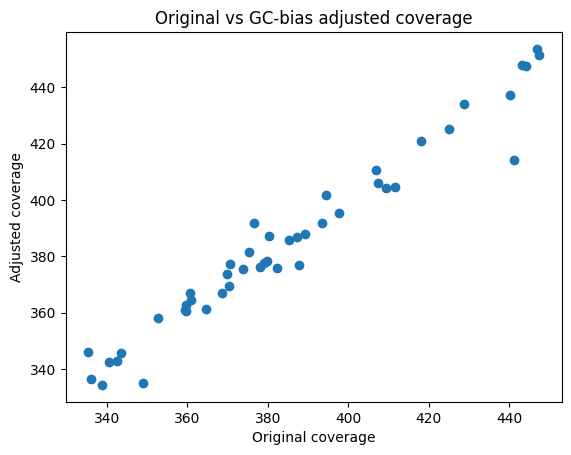

In [7]:
# Plot original vs adjusted coverage
import matplotlib.pyplot as plt
plt.scatter(merged['coverage'], merged['adjusted_coverage'])
plt.xlabel('Original coverage')
plt.ylabel('Adjusted coverage')
plt.title('Original vs GC-bias adjusted coverage')
plt.show()


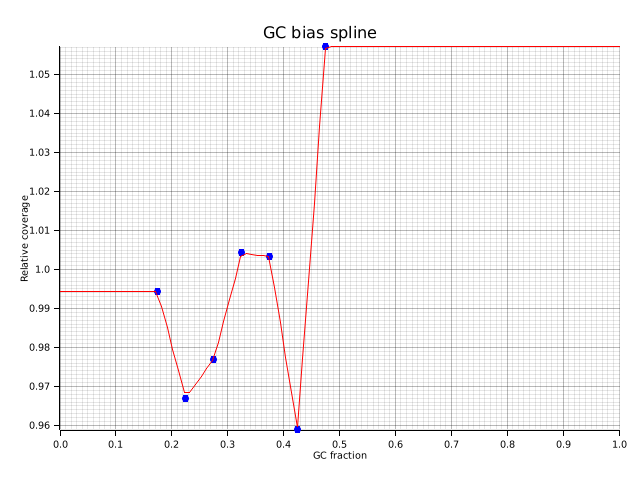

In [8]:

# Display GC-bias spline plot
from IPython.display import Image
Image('gc_bias.png')
